In [16]:
%load_ext autoreload

import numpy as np
import numpy.random as npr
import torch
import scipy as sp
from scipy import interpolate
from collections import defaultdict

import json
import pandas as pd
import os
from tqdm import tqdm
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
plt.style.use('bmh')
from matplotlib import cm
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

import dmc2gym

import pickle as pkl
import itertools
import operator
from collections import namedtuple
from glob import glob
import textwrap

import os
import yaml

import sys
# sys.path.append('../batch')
# %autoreload 2
# %aimport bcq

import omegaconf
from omegaconf import OmegaConf

%autoreload 2
from mve.analysis import plot_ac_exp, plot_comparison

from IPython.display import display
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


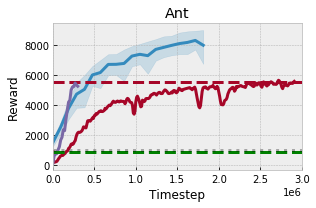

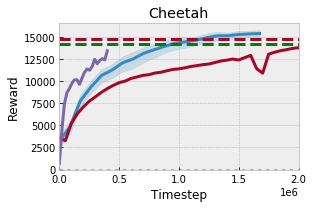

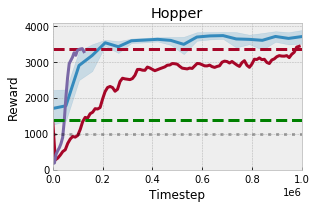

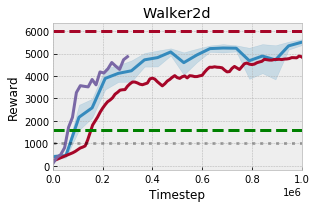

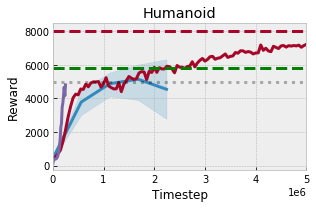

In [17]:
d = '../exp/2020.05.11/1234_sac_mve_mbpo_10/'
plot_comparison(
#     ac_base='../exp/attic/ant',
#     ac_is=['4.1', '4.2', '4.3', '4.4'],
    ac_base = d,
    ac_is=[f'{i}' for i in range(10,19+1)],
    mbpo_f='../data/mbpo/ant_mbpo.pkl',
    sac_f='../data/sac/ant.csv',
    save='../data/fig/mbpo_ant.pdf',
    title='Ant',
    xmax=3e6,
    steve=(2000./4.)*1.8,
    sac_scale=5.5/5.1,
    alive_bonus=1000.,
)

#d = '../exp/2020.05.04/1703_mbpo_others/'
#d = '../exp/2020.05.09/1540_ant_cheetah/'
d = '../exp/2020.05.11/1234_sac_mve_mbpo_10/'
plot_comparison(
    ac_base=d,
    ac_is=[f'{i}' for i in range(0,9+1)],
    mbpo_f='../data/mbpo/cheetah_mbpo.pkl',
    sac_f='../data/sac/cheetah.csv',
    save='../data/fig/mbpo_cheetah.pdf',
    title='Cheetah',
    xmax=2e6,
    steve=14200,
    sac_scale=15000/14000,
    alive_bonus=0.,
)


# d = '../exp/2020.05.04/1703_mbpo_others/'
d = '../exp/2020.05.09/1525_sac_mve_mbpo_10'
plot_comparison(
    ac_base=d,
    ac_is=[f'{i}' for i in range(0,7+1)],
    mbpo_f='../data/mbpo/hopper_mbpo.pkl',
    sac_f='../data/sac/hopper.csv',
    save='../data/fig/mbpo_hopper.pdf',
    title='Hopper',
    xmax=1e6,
    steve=(3000./5.)*2.3,
    alive_bonus=1000.,
)

# d = '../exp/2020.05.04/1703_mbpo_others/'
d = '../exp/2020.05.09/1525_sac_mve_mbpo_10'
plot_comparison(
    ac_base=d,
    ac_is=[f'{i}' for i in range(10,19+1)],
    mbpo_f='../data/mbpo/walker2d_mbpo.pkl',
    sac_f='../data/sac/walker.csv',
    save='../data/fig/mbpo_walker.pdf',
    title='Walker2d',
    xmax=1e6,
    steve=(4000./5.)*2,
    alive_bonus=1000.,
)

plot_comparison(
#     ac_base='../exp/attic/humanoid',
#     ac_is=['19.1', '19.2', '19.3', '19.4'],
    ac_base = d,
    ac_is=[f'{i}' for i in range(20,29+1)],
    mbpo_f='../data/mbpo/humanoid_mbpo.pkl',
    sac_f='../data/sac/humanoid.csv',
    save='../data/fig/mbpo_humanoid.pdf',
    title='Humanoid',
    xmax=5e6,
#     xmax=1.4e6,
    steve=5800,
    alive_bonus=5000.,
    n_interp=5,
)